# Import Modules

In [2]:
import numpy as np
import tensorflow as tf
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, mean_squared_error, explained_variance_score, silhouette_samples, silhouette_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Data Preprocessing

In [3]:
# Read CSV
df = pd.read_csv("./data/data.csv")
df.head()

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR)
0,0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005,Yes,106.81667,-6.2,4210.7
1,1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910,Yes,106.81667,-6.2,3511.3
2,2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545,Yes,106.81667,-6.2,6983.6
3,3,28,Jakarta,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,136.240,Yes,106.81667,-6.2,6503.9
4,4,49,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Debit,134.810,Yes,106.81667,-6.2,6942.0


In [3]:
# Check Total Unique Values in Location
unique_locations = df['Location'].nunique()

# Check total nulls
nullcounter = df.isnull().sum()
print("Total Unique Locations: ", unique_locations)
print(nullcounter)

Total Unique Locations:  2
Customer ID                     0
Tenure Months                   0
Location                        0
Device Class                    0
Games Product                   0
Music Product                   0
Education Product               0
Call Center                     0
Video Product                   0
Use MyApp                       0
Payment Method                  0
Monthly Purchase (Thou. IDR)    0
Churn Label                     0
Longitude                       0
Latitude                        0
CLTV (Predicted Thou. IDR)      0
dtype: int64


In [4]:
# Drop Customer ID
df = df.drop(columns="Customer ID")

# Replace Values
df = df.replace({'No': 0, 'Yes': 1, 'No internet service': 2})
df['Location'] = df['Location'].map({'Jakarta': 1, 'Bandung': 0})
df['Payment Method'] = df['Payment Method'].map({'Digital Wallet': 0, 'Pulsa': 1, 'Debit': 2, 'Credit': 3})
df['Device Class'] = df['Device Class'].map({'Low End': 0, 'Mid End': 1, 'High End': 2})
df.head()

,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR)
0,2,1,1,1,1,0,0,0,0,0,70.005,1,106.81667,-6.2,4210.7
1,2,1,2,0,0,0,0,0,0,1,91.910,1,106.81667,-6.2,3511.3
2,8,1,2,0,0,1,0,1,1,1,129.545,1,106.81667,-6.2,6983.6
3,28,1,2,0,0,1,1,1,1,1,136.240,1,106.81667,-6.2,6503.9
4,49,1,2,0,1,1,0,1,1,2,134.810,1,106.81667,-6.2,6942.0


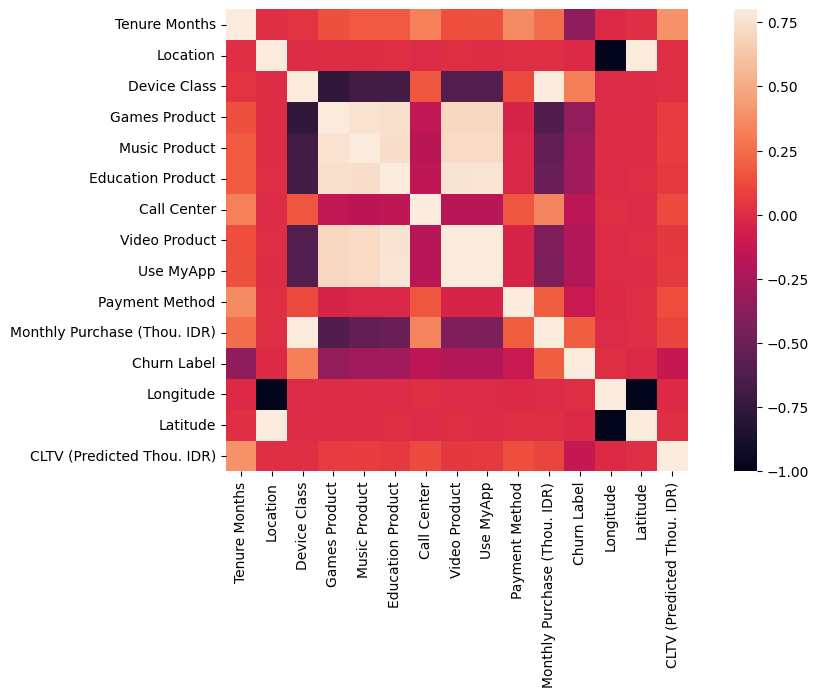

In [5]:
# Get Correlation Matrix
corrmat= df.corr()
fig = plt.figure(figsize = (12 ,6))
sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

In [106]:
# Read CSV and Drop Customer ID
df = pd.read_csv("./data/data.csv").drop(columns="Customer ID")

# Replace Values
df = df.replace({'No': 0, 'Yes': 1, 'No internet service': 2})
df['Location'] = df['Location'].map({'Jakarta': 1, 'Bandung': 0})

# One hot encode Location and Device Class column
df_encoded = pd.get_dummies(df, columns=['Device Class'], prefix='is', dtype=int)
df_encoded = pd.get_dummies(df_encoded, columns=['Payment Method'], prefix='use', dtype=int)

# Move the "Churn Label" column to the right
churn_label = df_encoded.pop('Churn Label')  # Remove the column
df_encoded['Churn Label'] = churn_label 
df_encoded.head()

,Tenure Months,Location,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Monthly Purchase (Thou. IDR),Longitude,Latitude,CLTV (Predicted Thou. IDR),is_High End,is_Low End,is_Mid End,use_Credit,use_Debit,use_Digital Wallet,use_Pulsa,Churn Label
0,2,1,1,1,0,0,0,0,70.005,106.81667,-6.2,4210.7,0,0,1,0,0,1,0,1
1,2,1,0,0,0,0,0,0,91.910,106.81667,-6.2,3511.3,1,0,0,0,0,0,1,1
2,8,1,0,0,1,0,1,1,129.545,106.81667,-6.2,6983.6,1,0,0,0,0,0,1,1
3,28,1,0,0,1,1,1,1,136.240,106.81667,-6.2,6503.9,1,0,0,0,0,0,1,1
4,49,1,0,1,1,0,1,1,134.810,106.81667,-6.2,6942.0,1,0,0,0,1,0,0,1


# Machine Learning

In [123]:
# Assign X and Y for Customer Segmentation
X_segment, Y_segment = df_encoded[["Games Product", "Music Product", "Education Product", "Call Center", "Video Product", "Use MyApp", "Monthly Purchase (Thou. IDR)", "is_High End", "is_Low End", "is_Mid End"]], df_encoded["Churn Label"]

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_segment)

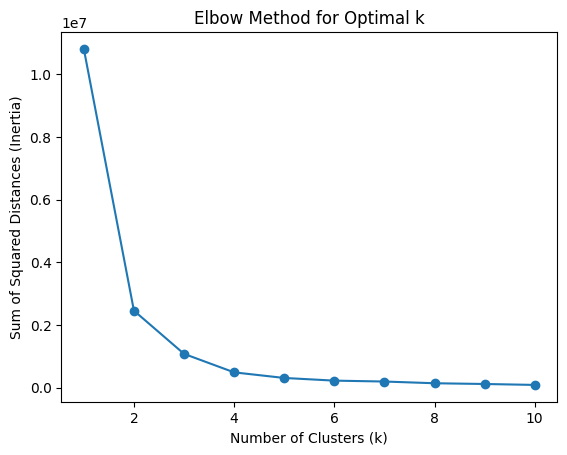

In [125]:
# Check Elbow Method
k_values = range(1, 11)

# Sum of squared distances for each k
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_segment)
    inertia_values.append(kmeans.inertia_)

# Plotting the Elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.6591222571848557
For n_clusters = 3 The average silhouette_score is : 0.6241557248102538
For n_clusters = 4 The average silhouette_score is : 0.639690933250088
For n_clusters = 5 The average silhouette_score is : 0.6125464302115129
For n_clusters = 6 The average silhouette_score is : 0.5963501044613491
For n_clusters = 7 The average silhouette_score is : 0.5980263925512822
For n_clusters = 8 The average silhouette_score is : 0.5684253840099002
For n_clusters = 9 The average silhouette_score is : 0.5734197462089115


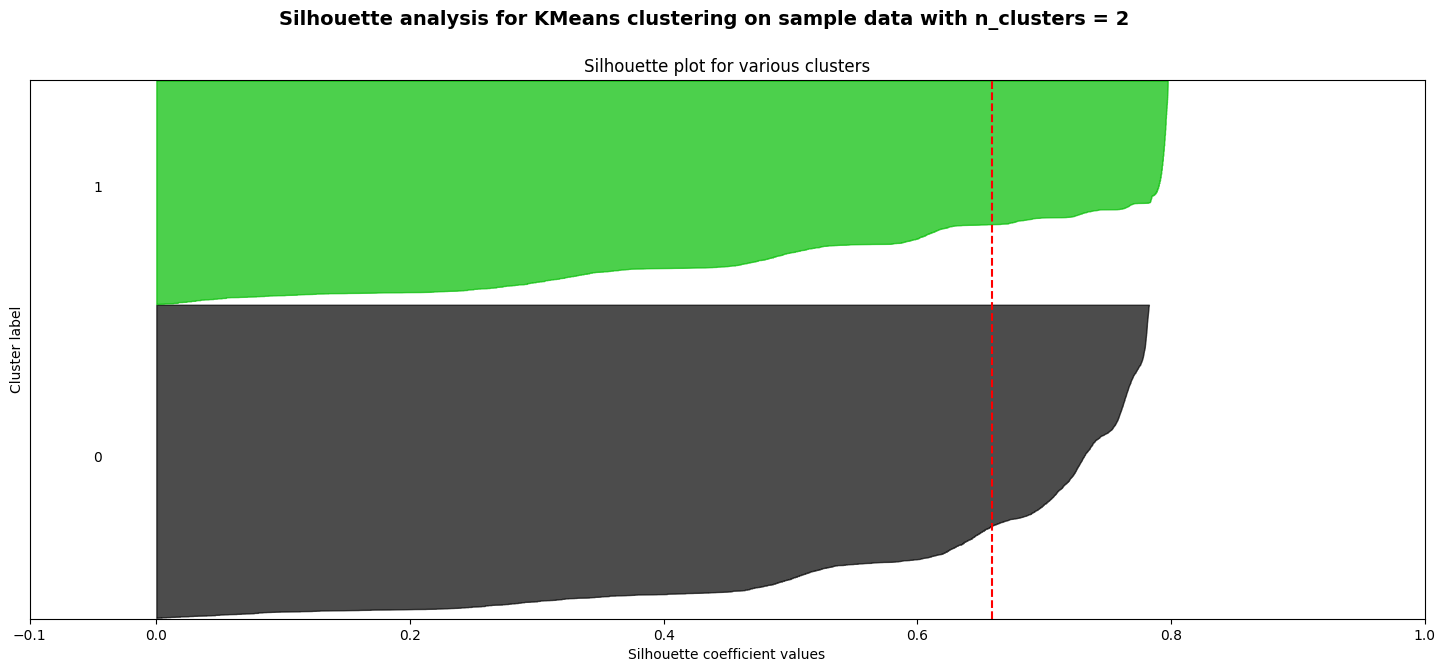

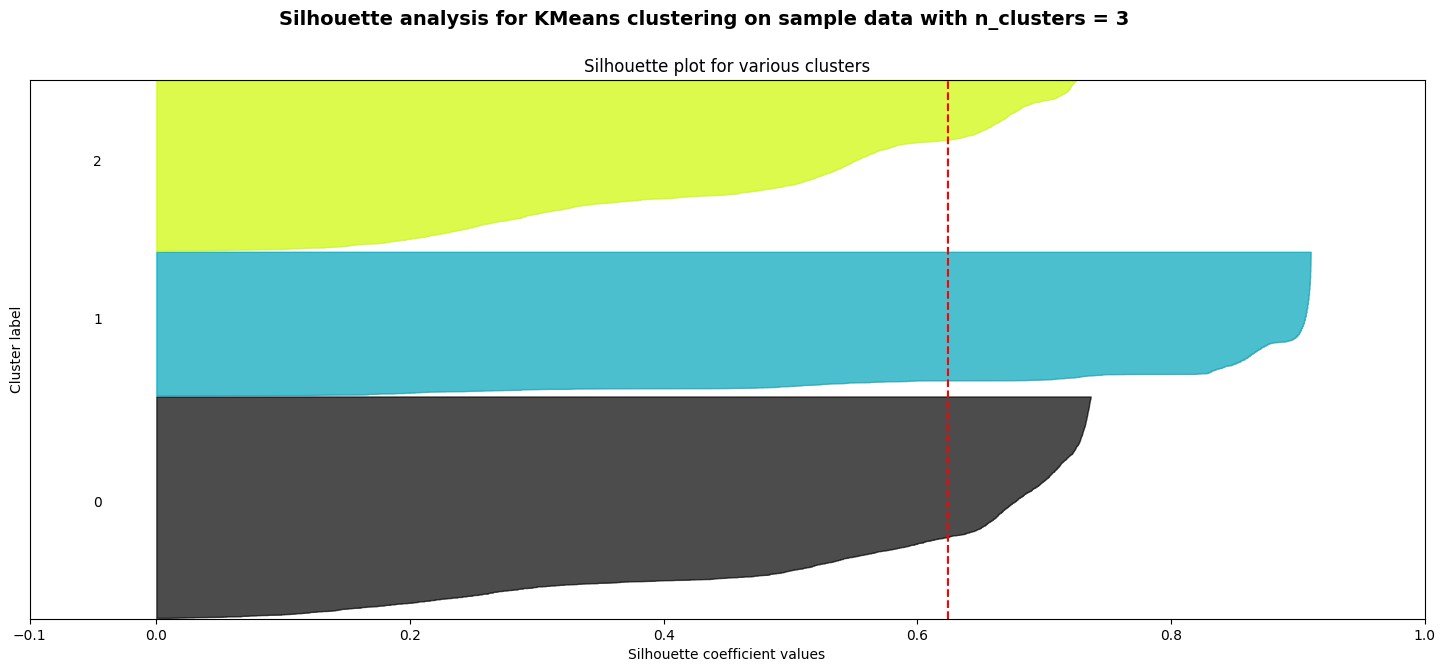

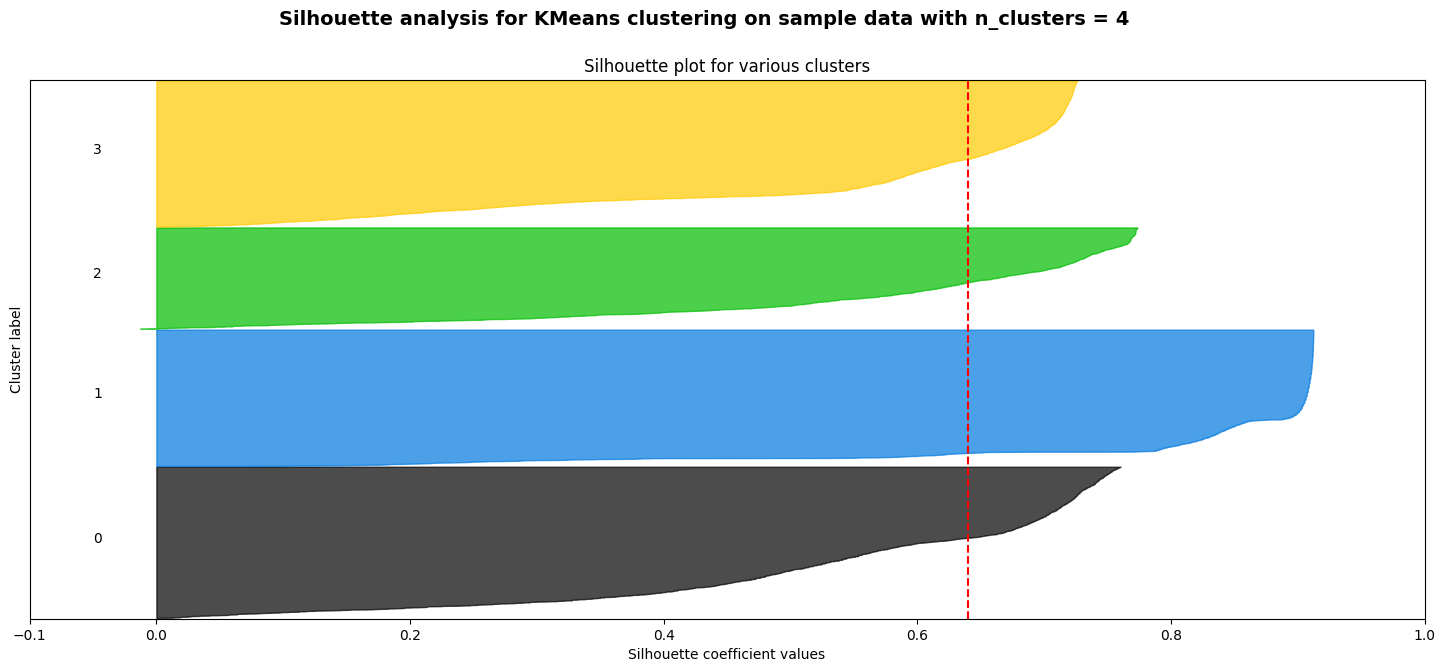

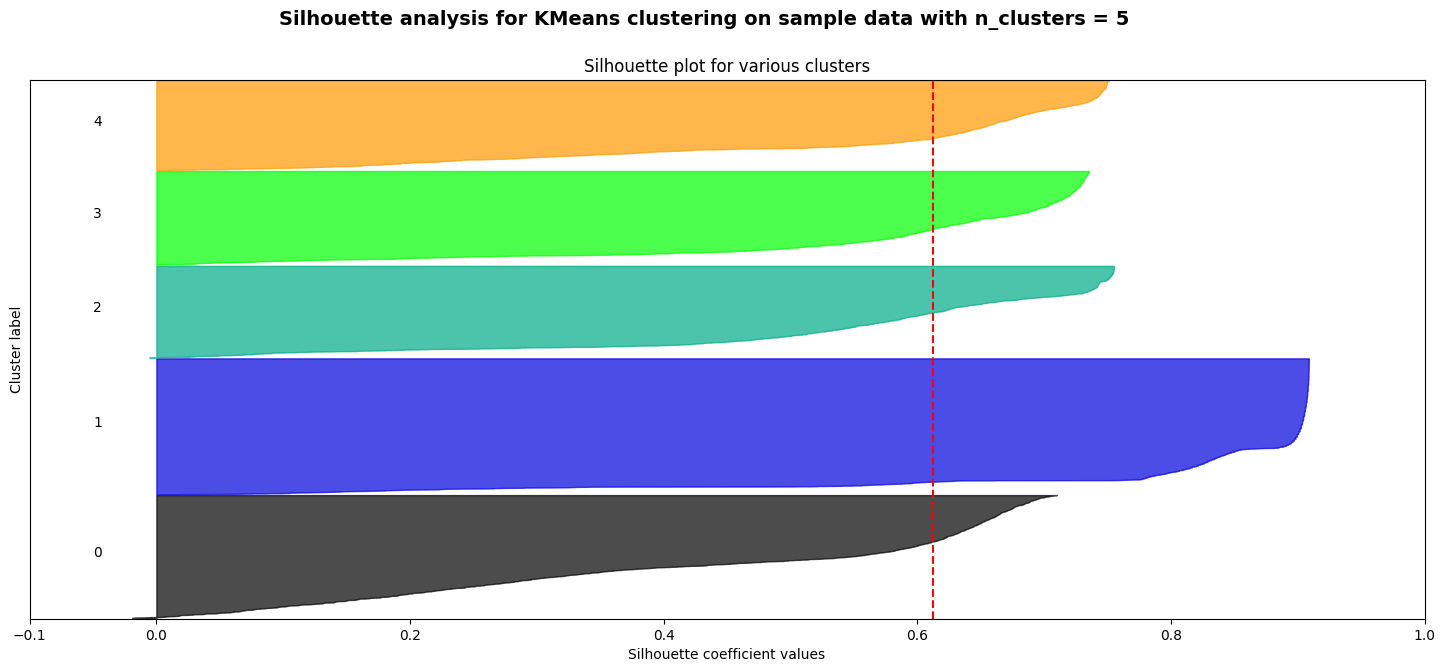

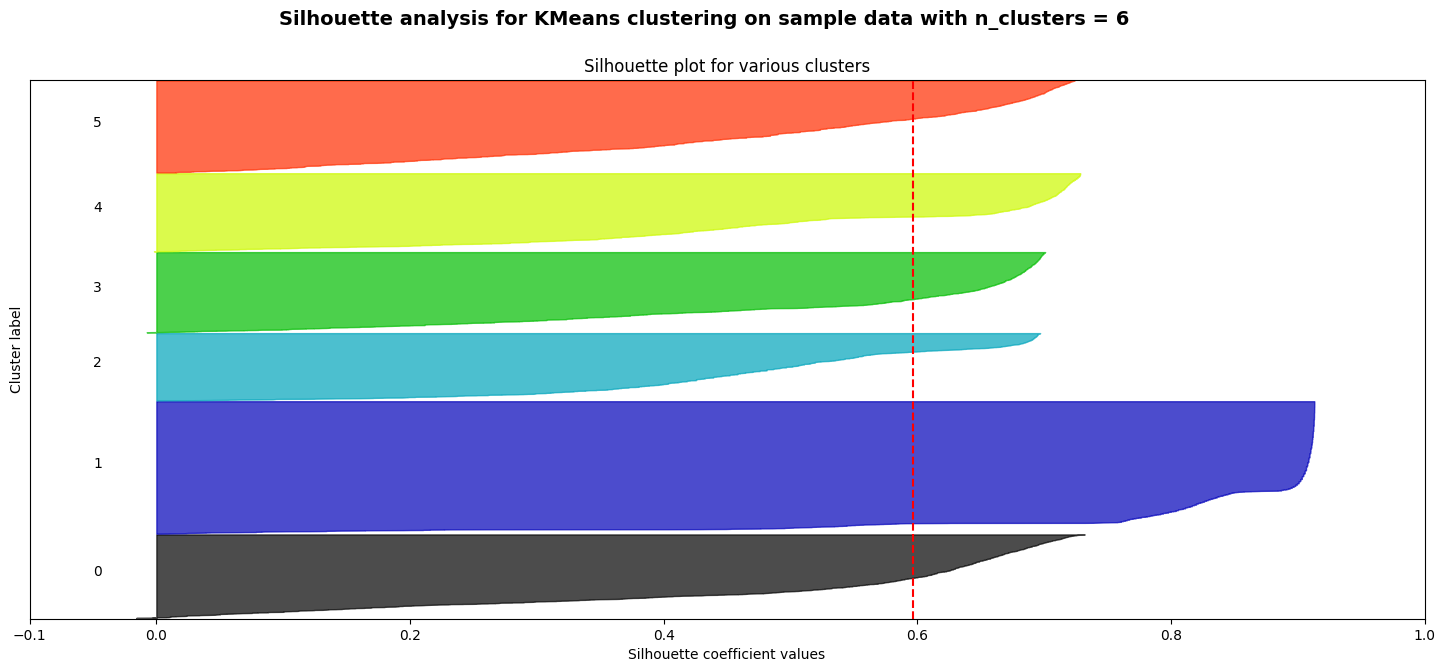

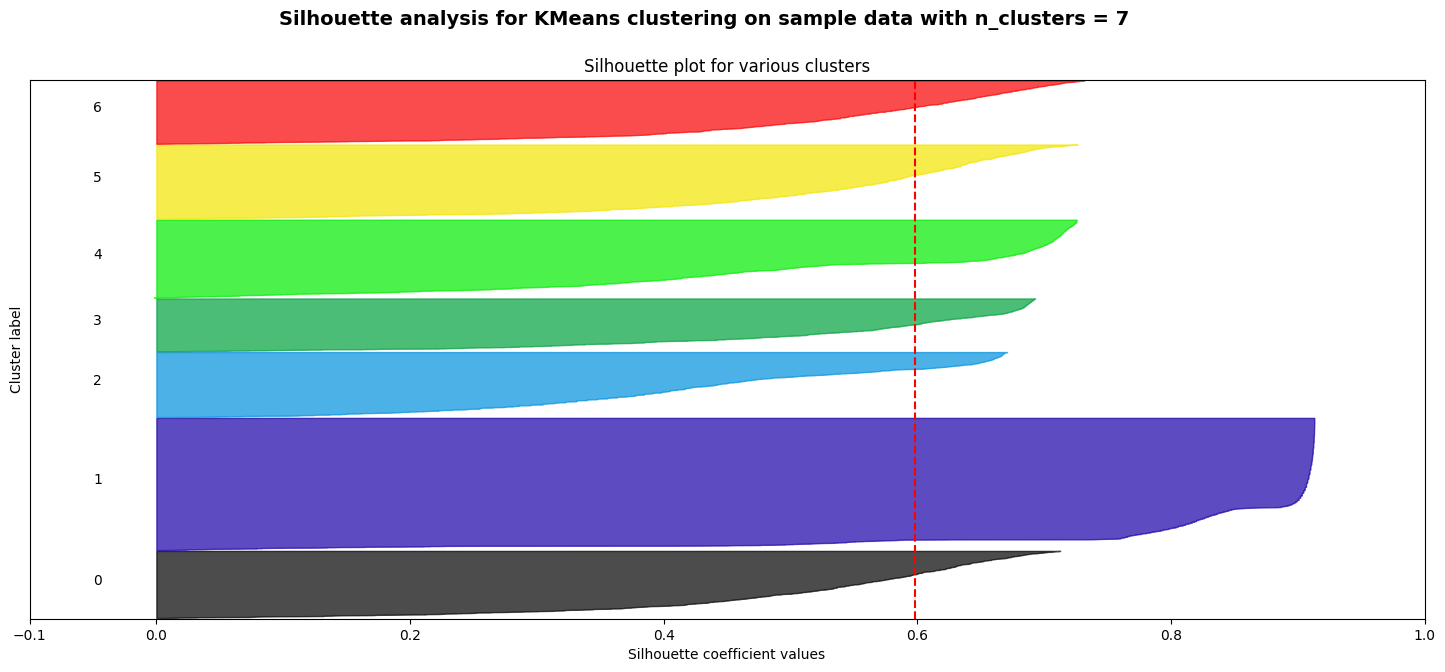

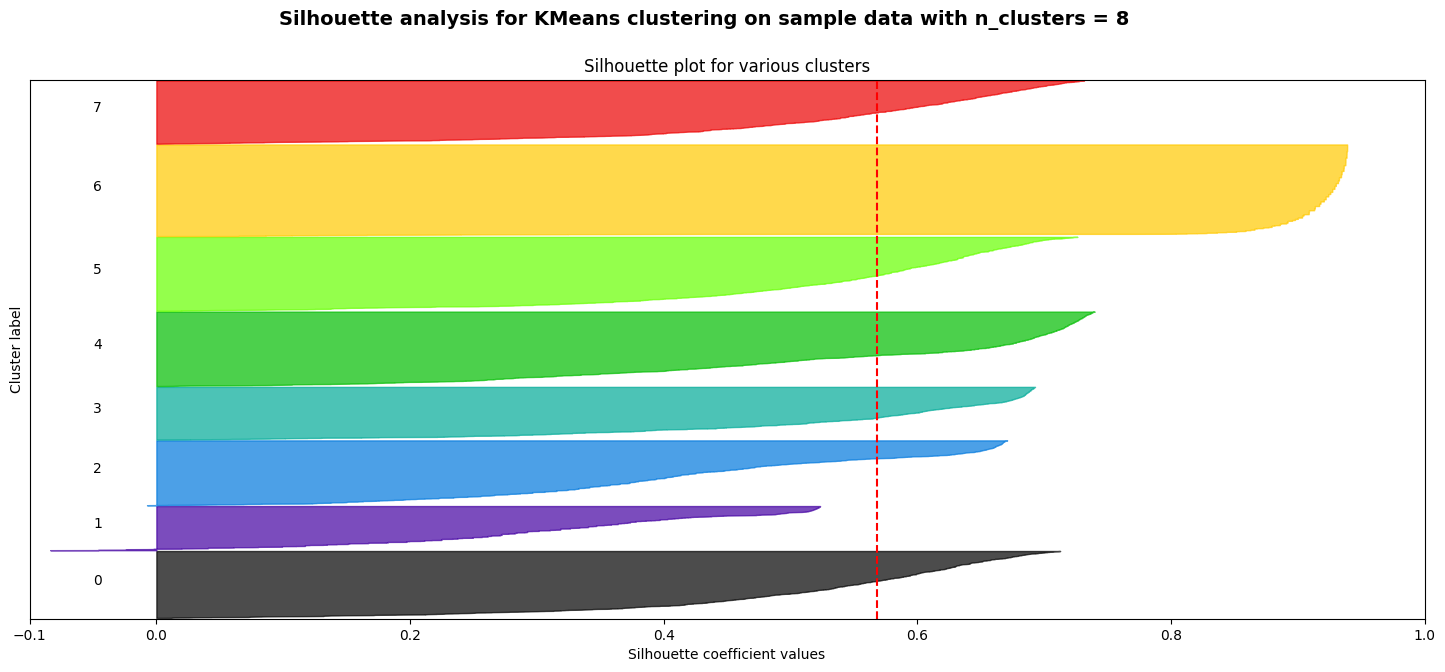

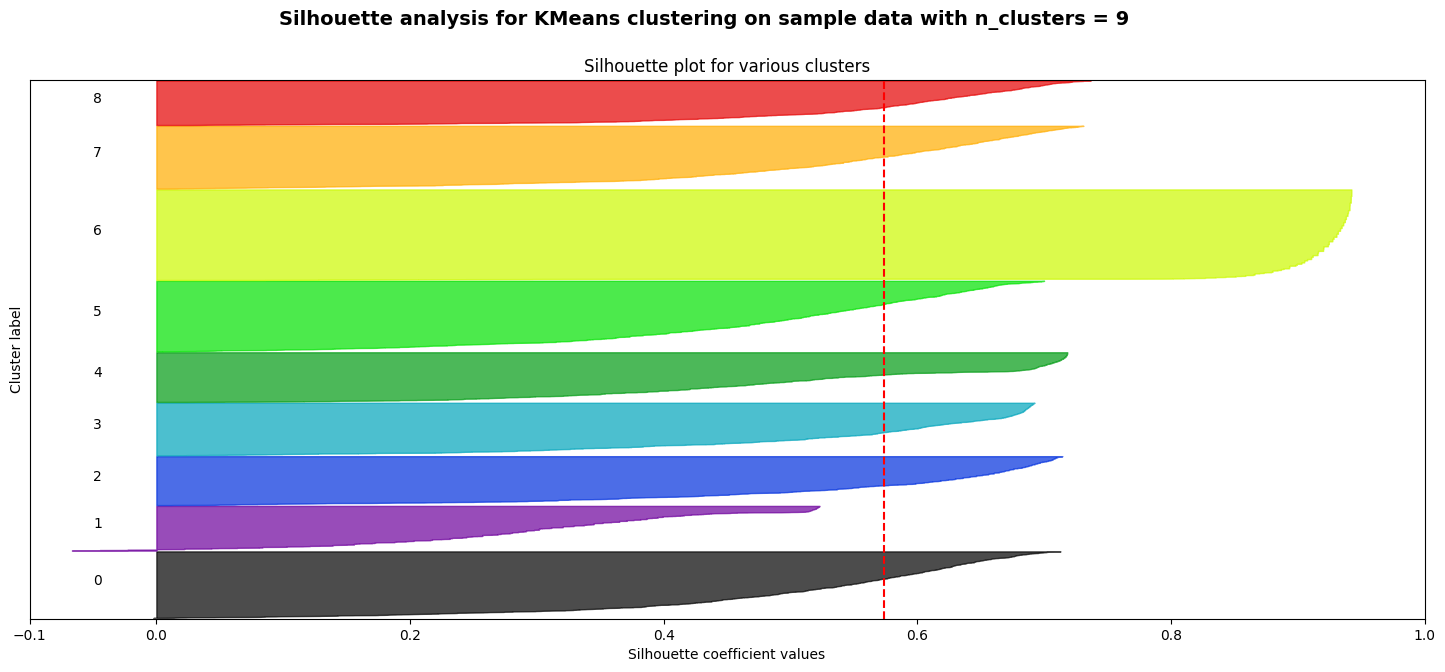

In [126]:
# Check Silhouette Score to determine K
# Range of k values
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_segment) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X_segment)

    silhouette_avg = silhouette_score(X_segment, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X_segment, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot for various clusters")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


In [127]:
# Apply K-Means clustering
# Since k=4 has a better distribution and silhouette score, we will assign n_clusters = 4
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
X_segment.loc[:, 'Cluster'] = kmeans.fit_predict(X_scaled)

# Analyze cluster characteristics
cluster_means = X_segment.groupby('Cluster').mean()

# Generate Total Churn for Each Clusters
df_segment = df_encoded.copy()
df_segment['Cluster'] = kmeans.fit_predict(X_scaled)
df_segment["Churn Label"] = df_segment["Churn Label"].astype(int)

# Calculate the total churn labels for each cluster
total_churn_labels = df_segment.groupby('Cluster')['Churn Label'].sum()

# Add the total churn labels column to the cluster_means DataFrame
cluster_means['Total Churn Labels'] = total_churn_labels

# Display the updated cluster_means DataFrame
cluster_means.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8232\2125069715.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_segment.loc[:, 'Cluster'] = kmeans.fit_predict(X_scaled)


,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Monthly Purchase (Thou. IDR),is_High End,is_Low End,is_Mid End,Total Churn Labels
Cluster,,,,,,,,,,,
0,0.270995,0.433786,0.438307,0.279716,0.565245,0.565568,118.950168,1.0,0.0,0.0,1297
1,2.000000,2.000000,2.000000,0.000000,2.000000,2.000000,27.402952,0.0,1.0,0.0,113
2,0.366050,0.358809,0.323411,0.000000,0.292035,0.308930,66.279240,0.0,0.0,1.0,345
3,0.615450,0.543294,0.562818,1.000000,0.504244,0.506791,85.296995,0.0,0.0,1.0,114


In [129]:
# Map the Cluster
def map_product_usage(value):
    if value == 0:
        return 'No Tendency'
    elif 0 < value < 0.5:
        return 'Low Usage'
    elif 0.5 <= value < 1:
        return 'Moderate Usage'
    elif value == 1:
        return 'Using'
    elif value == 2:
        return 'No Service'
    else:
        return 'Undefined'
    
# Define a mapping function for device type
def map_device_type(row):
    if row['is_High End'] == 1:
        return 'High End'
    elif row['is_Low End'] == 1:
        return 'Low End'
    elif row['is_Mid End'] == 1:
        return 'Mid End'
    else:
        return 'Undefined'
    
# Define a mapping function for purchase level
def map_purchase_level(value):
    if value > 100:
        return 'High'
    elif value > 50:
        return 'Moderate'
    else:
        return 'Low'

# Apply the mapping function to create the "Purchase Level" column
cluster_means['Monthly Purchase Level'] = cluster_means['Monthly Purchase (Thou. IDR)'].apply(map_purchase_level)

# Apply the mapping function to the product columns in the cluster_means DataFrame
product_columns = ['Games Product', 'Music Product', 'Education Product', 'Call Center', 'Video Product', 'Use MyApp']

for column in product_columns:
    cluster_means[column] = cluster_means[column].apply(map_product_usage)


# Apply the mapping function to create the "Device" column
cluster_means['Device'] = cluster_means.apply(map_device_type, axis=1)

# Reorder columns, moving "Device" to the left of "Total Churn Labels"
columns_order = ['Games Product', 'Music Product', 'Education Product', 'Call Center', 'Video Product', 'Use MyApp',
                 'Monthly Purchase Level', 'Device', 'Total Churn Labels']

cluster_means = cluster_means[columns_order]

# Export CSV
cluster_means.to_csv("./data/clusters.csv")

# Display the updated cluster_means DataFrame
cluster_means.head()

,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Monthly Purchase Level,Device,Total Churn Labels
Cluster,,,,,,,,,
0,Low Usage,Low Usage,Low Usage,Low Usage,Moderate Usage,Moderate Usage,High,High End,1297
1,No Service,No Service,No Service,No Tendency,No Service,No Service,Low,Low End,113
2,Low Usage,Low Usage,Low Usage,No Tendency,Low Usage,Low Usage,Moderate,Mid End,345
3,Moderate Usage,Moderate Usage,Moderate Usage,Using,Moderate Usage,Moderate Usage,Moderate,Mid End,114


### Churn Prediction

In [152]:
# Split Into Training and Test Set
X_churn, Y_churn = df_encoded.drop(columns=["Longitude", "Latitude", "CLTV (Predicted Thou. IDR)", "Churn Label"]), df_encoded["Churn Label"]
X_train, X_test, Y_train, Y_test = train_test_split(X_churn, Y_churn, test_size=0.2, random_state=20)

In [153]:
# Create and train the Random Forest model
model = LogisticRegression(max_iter=10000)
model.fit(X_train, Y_train)
    
# Evaluate the model
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
classification_rep = classification_report(Y_test, Y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

Accuracy: 0.8041163946061036
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.92      0.87      1042
           1       0.67      0.49      0.56       367

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



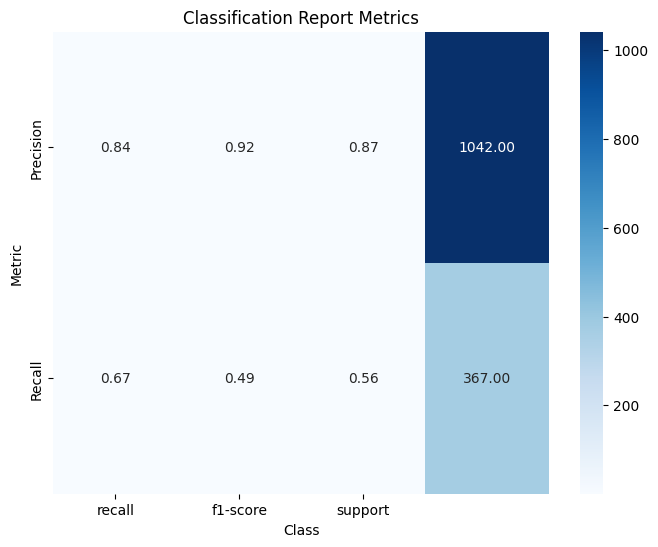

In [157]:
# Function to extract values from the classification report
def extract_metrics(report):
    lines = report.split('\n')
    class_names = lines[0].split()
    values = [list(map(float, line.split()[1:])) for line in lines[2:4]]
    return class_names, values

# Function to plot a confusion matrix
def plot_classification_report(class_names, values):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(values, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names[1:], yticklabels=['Precision', 'Recall'])
    plt.xlabel('Class')
    plt.ylabel('Metric')
    plt.title('Classification Report Metrics')
    plt.show()

# Plotting the classification report
class_names, values = extract_metrics(classification_rep)
plot_classification_report(class_names, values)

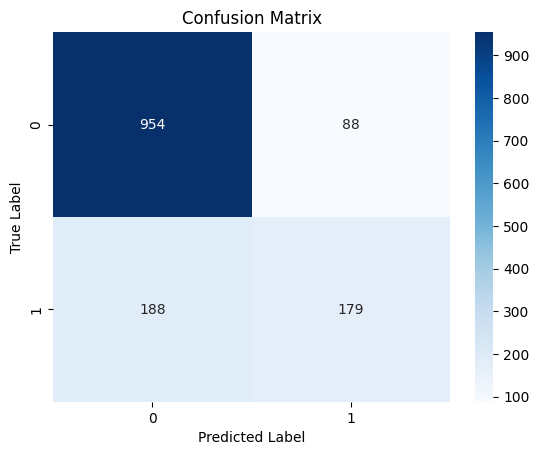

In [144]:
# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

ROC-AUC Score: 0.8478690633711109


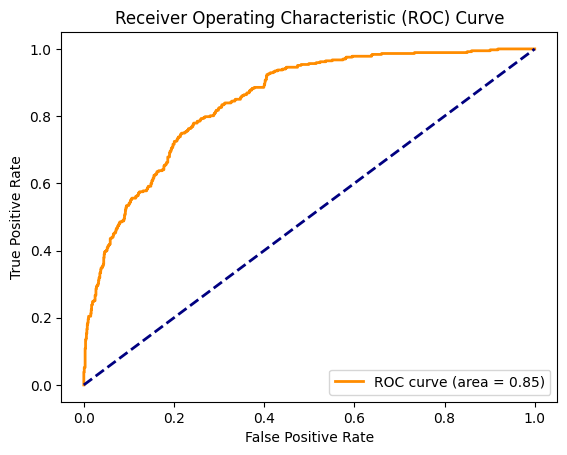

In [145]:
# ROC-AUC Score and Curve
roc_auc = roc_auc_score(Y_test, model.predict_proba(X_test)[:, 1])
print("ROC-AUC Score:", roc_auc)

fpr, tpr, _ = roc_curve(Y_test, model.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### CLTV Forecasting

In [160]:
# Split Into Training and Test Set
X_cltv, Y_cltv = df_encoded.drop(columns=["Longitude", "Latitude", "CLTV (Predicted Thou. IDR)", "Churn Label"]), df_encoded["CLTV (Predicted Thou. IDR)"]
X_train, X_test, Y_train, Y_test = train_test_split(X_cltv, Y_cltv, test_size=0.2, random_state=20)

In [161]:
# Regression Model to Predict CLTV
regmodel = LinearRegression()
regmodel.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = regmodel.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
std = df["CLTV (Predicted Thou. IDR)"].values.std()

print("Dataset Standard Deviation:", std)
print("Mean Absolute Error:", mae)
print("R-squared (R2) Score:", r2)

Dataset Standard Deviation: 1537.8651090608005
Mean Absolute Error: 1195.4085817102011
R-squared (R2) Score: 0.1727984526563291


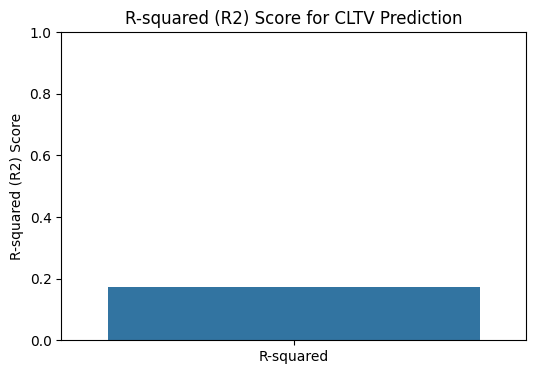

In [162]:
# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=['R-squared'], y=[r2])
plt.ylim(0, 1)  # R2 score ranges from 0 to 1
plt.ylabel('R-squared (R2) Score')
plt.title('R-squared (R2) Score for CLTV Prediction')
plt.show()

In [62]:
with open('./model/kmeans.pkl', 'rb') as model_file:
    kmeansmodel = pickle.load(model_file)

### Export Model

In [134]:
# Export Churn Model
with open('./model/churnmodel.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Export CLTV Model
with open('./model/cltvmodel.pkl', 'wb') as model_file:
    pickle.dump(regmodel, model_file)

# Export Kmeans Model
with open('./model/kmeans.pkl', 'wb') as model_file:
    pickle.dump(kmeans, model_file)

# Export Scaler
joblib.dump(scaler, './model/scaler_model.pkl')

['./model/scaler_model.pkl']

# This code is written by the Lashani Team for the purpose of the Data Science Weekend 2023 Competition.